In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

Number of instances: 18846
Number of classes: 20

Classes in dataset:
0: alt.atheism (799 posts)
1: comp.graphics (973 posts)
2: comp.os.ms-windows.misc (985 posts)
3: comp.sys.ibm.pc.hardware (982 posts)
4: comp.sys.mac.hardware (963 posts)
5: comp.windows.x (988 posts)
6: misc.forsale (975 posts)
7: rec.autos (990 posts)
8: rec.motorcycles (996 posts)
9: rec.sport.baseball (994 posts)
10: rec.sport.hockey (999 posts)
11: sci.crypt (991 posts)
12: sci.electronics (984 posts)
13: sci.med (990 posts)
14: sci.space (987 posts)
15: soc.religion.christian (997 posts)
16: talk.politics.guns (910 posts)
17: talk.politics.mideast (940 posts)
18: talk.politics.misc (775 posts)
19: talk.religion.misc (628 posts)


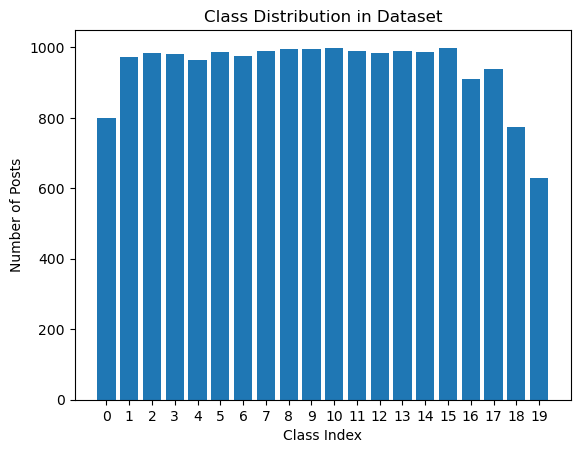


Sample post (first 300 chars):
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent

Issues that cause overfitting:
- Email headers (From:, Subject:, Date:)
- Quoted text from previous messages
- Email signatures and footers

 Loading..
Cleaned dataset loaded.


In [ ]:
#loading the dataset
newsgroups = fetch_20newsgroups(subset='all')
X = newsgroups.data
y = newsgroups.target
target_names = newsgroups.target_names

# 1a): How many instances (examples) and variables are in the dataset?
print(f"Number of instances: {len(X)}")
print(f"Number of classes: {len(target_names)}")

# 1b): How many and which classes does the dataset define? What is their share in the data?
print("\nClasses in dataset:")
for i, name in enumerate(target_names):
    count = sum(y == i)
    print(f"{i}: {name} ({count} posts)")

# 1c): Plot class distribution
class_counts = [sum(y == i) for i in range(len(target_names))]

plt.bar(range(len(target_names)), class_counts)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class Index')
plt.ylabel('Number of Posts')
plt.xticks(range(len(target_names)))
plt.show()

# 1d): Is there anything in the examples that might cause a classifier to overfit to the training data? How can you fix this?
print("\nSample post (first 300 chars):")
print(X[0][:300])

print("\nIssues that cause overfitting:")
print("- Email headers (From:, Subject:, Date:)")
print("- Quoted text from previous messages") 
print("- Email signatures and footers")

print("\n Loading..")
newsgroups_clean = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
X = newsgroups_clean.data
y = newsgroups_clean.target

print("Cleaned dataset loaded.")


Training set size: 15076
Test set size: 3770


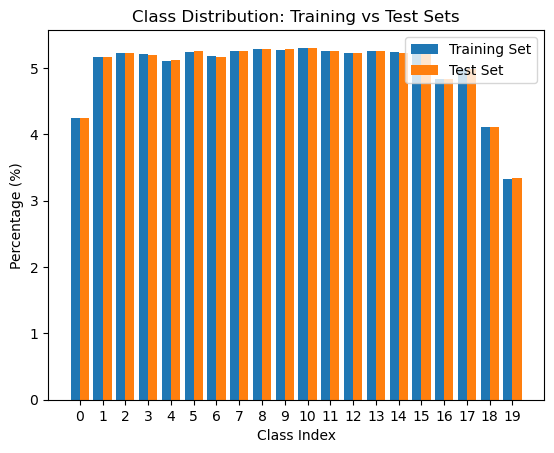

In [20]:
# 2a): Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# 2b): Check equal distribution
train_dist = [sum(y_train == i) / len(y_train) * 100 for i in range(len(target_names))]
test_dist = [sum(y_test == i) / len(y_test) * 100 for i in range(len(target_names))]

plt.figure()
x_pos = np.arange(len(target_names))
plt.bar(x_pos - 0.2, train_dist, 0.4, label='Training Set')
plt.bar(x_pos + 0.2, test_dist, 0.4, label='Test Set')
plt.xlabel('Class Index')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution: Training vs Test Sets')
plt.legend()
plt.xticks(x_pos)
plt.show()

In [4]:
# 3a): How many attributes do we get from this feature engineering/extraction? Do you think this is a good number? Why (not)?
vectorizer_basic = CountVectorizer()
X_train_basic = vectorizer_basic.fit_transform(X_train)

print(f"\n3a) Number of features with basic CountVectorizer: {X_train_basic.shape[1]}")
print("Not a good number--too many features will cause overfitting and poor KNN performance")

# 3b): How many attributes do you get after that change?
vectorizer = CountVectorizer(max_df=0.5, min_df=0.001)
X_train_features = vectorizer.fit_transform(X_train)

print(f"\n3b) Number of features after filtering: {X_train_features.shape[1]}")

# 3c): Apply a TfidfTransformer
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_features)
X_test_tfidf = tfidf.transform(vectorizer.transform(X_test))

print("3c) TfidfTransformer applied successfully")


3a) Number of features with basic CountVectorizer: 123548
Not a good number--too many features will cause overfitting and poor KNN performance

3b) Number of features after filtering: 9123
3c) TfidfTransformer applied successfully


In [5]:
# 4a): Train KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf, y_train)

# 4b): How many neighbors does the classifier use?
print(f"\n4b) Number of neighbors: {knn.n_neighbors}")

# 4c): 5-fold cross-validation
cv_results = cross_validate(knn, X_train_tfidf, y_train, cv=5, return_train_score=True)

train_accuracy = cv_results['train_score'].mean()
validation_accuracy = cv_results['test_score'].mean()

print(f"\n4c) Cross-validation results:")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Validation accuracy: {validation_accuracy:.3f}")

# 4d): What do the numbers tell you about overfitting/underfitting of the model?
accuracy_gap = train_accuracy - validation_accuracy
print(f"\n4d) Overfitting analysis:")
print(f"Accuracy gap: {accuracy_gap:.3f}")

if accuracy_gap > 0.05:
    print("Model shows overfitting (training >> validation accuracy)")
else:
    print("Model shows good fit")

# 4e): How well does this model perform in comparision?
nb = MultinomialNB()
nb_cv_results = cross_validate(nb, X_train_tfidf, y_train, cv=5)
nb_accuracy = nb_cv_results['test_score'].mean()

print(f"\n4e) Naive Bayes comparison:")
print(f"KNN validation accuracy: {validation_accuracy:.3f}")
print(f"Naive Bayes validation accuracy: {nb_accuracy:.3f}")

if nb_accuracy > validation_accuracy:
    print("Naive Bayes performs better")
else:
    print("KNN performs better")




4b) Number of neighbors: 5

4c) Cross-validation results:
Training accuracy: 0.370
Validation accuracy: 0.108

4d) Overfitting analysis:
Accuracy gap: 0.261
Model shows overfitting (training >> validation accuracy)

4e) Naive Bayes comparison:
KNN validation accuracy: 0.108
Naive Bayes validation accuracy: 0.688
Naive Bayes performs better


In [6]:
# 5a): Create pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', KNeighborsClassifier())
])

print("\n5a) Pipeline created with CountVectorizer, TfidfTransformer, and KNeighborsClassifier")

# 5b): Hyperparameter tuning
param_grid = {
    'vectorizer__max_df': [0.3, 0.5, 0.7],
    'vectorizer__min_df': [0.001, 0.005],
    'classifier__n_neighbors': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"\n5b) Grid search completed")
print(f"Best parameters: {grid_search.best_params_}")

# 5c): Which parameter combination is best? How good is it? Does that model still suffer from overfitting?
best_cv_score = grid_search.best_score_
best_model = grid_search.best_estimator_

# Check training accuracy
train_pred = best_model.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)

print(f"\n5c) Results:")
print(f"Best parameter combination: {grid_search.best_params_}")
print(f"Cross-validation accuracy: {best_cv_score:.3f}")
print(f"Training accuracy: {train_acc:.3f}")

overfitting_gap = train_acc - best_cv_score
if overfitting_gap > 0.05:
    print("Model still shows some overfitting")
else:
    print("Overfitting is well controlled")

# 5d): Which of the tuned parameters seems to have the most influence on performance of the model (reducing overfitting or under-fitting)? Which parameters are independent/dependent on each other? 
results_df = pd.DataFrame(grid_search.cv_results_)

print(f"\n5d) Parameter influence analysis:")

# Check which parameter has most influence
for param in ['vectorizer__max_df', 'vectorizer__min_df', 'classifier__n_neighbors']:
    param_values = param_grid[param]
    param_scores = []
    for value in param_values:
        mask = results_df[f'param_{param}'] == value
        avg_score = results_df[mask]['mean_test_score'].mean()
        param_scores.append(avg_score)
    
    score_range = max(param_scores) - min(param_scores)
    print(f"{param}: score range = {score_range:.3f}")

print("Parameter with largest score range has most influence on performance")

# 5e): What is the best model you can come up with?
nb_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_df=0.5, min_df=0.001)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
nb_score = cross_validate(nb_pipeline, X_train, y_train, cv=3)['test_score'].mean()

print(f"\n5e) Other models tested:")
print(f"Naive Bayes pipeline: {nb_score:.3f}")
print(f"Best KNN pipeline: {best_cv_score:.3f}")

if nb_score > best_cv_score:
    print("Best model: Naive Bayes")
    final_score = nb_score
else:
    print("Best model: Tuned KNN")
    final_score = best_cv_score

print(f"Final best accuracy: {final_score:.3f}")



5a) Pipeline created with CountVectorizer, TfidfTransformer, and KNeighborsClassifier

5b) Grid search completed
Best parameters: {'classifier__n_neighbors': 3, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 0.005}

5c) Results:
Best parameter combination: {'classifier__n_neighbors': 3, 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 0.005}
Cross-validation accuracy: 0.142
Training accuracy: 0.584
Model still shows some overfitting

5d) Parameter influence analysis:
vectorizer__max_df: score range = 0.010
vectorizer__min_df: score range = 0.013
classifier__n_neighbors: score range = 0.018
Parameter with largest score range has most influence on performance

5e) Other models tested:
Naive Bayes pipeline: 0.675
Best KNN pipeline: 0.142
Best model: Naive Bayes
Final best accuracy: 0.675
